In [1]:
import sys
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python/")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/")
sys.path.append("/home/rossidaniel/Dropbox")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python")

In [2]:
import Bin_Packing_Py as BP
import BP_print
import BP_plot
import BP_utilities
import HA_routines
import BP_instances

import matplotlib
%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = [6,3.5]

from ortools.linear_solver import pywraplp
import random
import time
import csv

import pandas as pd
from sqlalchemy import create_engine
from mail import send_mail
from Test_BP_G import euristic

In [3]:
def tc_sfida():
    item_list = []
    bin_list = []

    bin_list.append(BP.Bin(2.70, 13.5, 2.45))
    bin_list.append(BP.Bin(0, 0, 0))

    n_items =random.randint(3,10)

    for i in range(n_items):
        w=random.uniform(0.5,2.45)
        d=random.uniform(0.5,1)
        h=random.uniform(0.5,1.5)
        item = BP.Item(i,h,d,w)
        item.stackable = random.randint(0,1)
        item.order_id = random.randint(1,5)
        item.weight = 4
        item_list.append(item)

    return item_list, bin_list

In [4]:
def checkStable(s):
    anchors = s.getAnchors(0)
    for a in anchors:
        eps = 1e-3

        if a.pos.z == 0:
            continue

        contact_area = 0;

        for b in anchors:
            if (a.pos == b.pos):
                continue
            if (round(b.pos.z + b.item.height,3) + eps == round(a.pos.z,3)):
                contact_area += a.getContactArea(a, b)
            if (round(b.pos.z + b.item.height,3) - eps == round(a.pos.z,3)):
                contact_area += a.getContactArea(a, b)
            if (round(b.pos.z + b.item.height,3) == round(a.pos.z,3)):
                contact_area += a.getContactArea(a, b)
        if contact_area + eps < a.item.getBaseArea(): return False
    return True

In [32]:
def checkSequence(solution):
    items =solution.getAnchors(0)
    for i in items:
        l,r,h = [0,0,0]
        for j in items:
            print i.item.id, j.item.id
            if (i.item.order_id < j.item.order_id and i != j):
                a_r = i.realDim()
                b_r = j.realDim()

                a_p = i.pos
                b_p = j.pos    
                
                #il pacco i è al di sotto dell'oggetto j
                if BP.Anchor.ProjectionCommonArea(i,j,BP.Direction.z) == True:
                    if round(a_p.z,6) + round(a_r.height,6) <= round(b_p.z,6): l=1;r=1;h=1
                #il pacco i è davanti o dietro il pacco j
                if BP.Anchor.ProjectionCommonArea(i,j,BP.Direction.y) == True:
                    if round(a_p.y,6) + round(a_r.depth,6) <= round(b_p.y,6): h+=1
                #il pacco i è a sinistra o a destra del pacco j
                if BP.Anchor.ProjectionCommonArea(i,j,BP.Direction.x) == True:
                    if round(b_p.x,6) + round(b_r.width,6) <= round(a_p.x,6): l+=1 
                    else: r +=1
            print 'ciucia'    
            print l,r,h
            if l*r*h > 0: return 0
    return 1

In [11]:
class model_bin_packing:
    def __init__(self,item_list,bin_list):
        self.bp = BP.BinPack()
        self.bp.items.extend(item_list)
        self.bp.bins.extend(bin_list)

    def buildModel(self,amount_time=300000):
        solver = pywraplp.Solver('Model3D', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        #importo dimensioni dei pacchi e del camion
        n=len(self.bp.items)

        #print [self.bp.items[i].stackable for i in range(n)]
        
        w =[self.bp.items[i].width for i in range(n)]
        d =[self.bp.items[i].depth for i in range(n)]
        h =[self.bp.items[i].height for i in range(n)]
        
        W =self.bp.bins[0].width
        D =solver.NumVar(0,sum([max(w[i],d[i]) for i in range(n)]),"D")
        H =self.bp.bins[0].height

        Mw=W+max(max(w),max(d))
        Md=self.bp.bins[0].depth+max(max(w),max(d))
        Mh=self.bp.bins[0].height+max(h)
                
        # definisco le variabili
        l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        t =[[solver.IntVar(0,self.bp.items[i].stackable,"t%d%d" % (i,j)) for j in range(n)] for i in range(n)]
        f =[[solver.IntVar(0,self.bp.items[i].stackable,"f%d%d" % (i,j)) for j in range(n)] for i in range(n)]
        k =[[solver.BoolVar("k%d%d" % (i,j)) for j in range(n)] for i in range(n)]
        r =[solver.BoolVar("r%d" % (i)) for i in range(n)]

        x =[solver.NumVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
        y =[solver.NumVar(0,solver.infinity(),"y%d" % i) for i in range(n)]
        z =[solver.NumVar(0,solver.infinity(),"z%d" % i) for i in range(n)]
        
        #definisco i constraints
        for i in range(n):
            for j in range(n):
                if(i < j):
                    solver.Add(k[i][j] <= l[i][j] + l[j][i] + b[i][j] + b[j][i])
                    solver.Add(2 * k[i][j] >= l[i][j] + l[j][i] + b[i][j] + b[j][i])
                    solver.Add(1 - k[i][j] == t[i][j] + t[j][i])
                if(i != j):
                    solver.Add(x[i] - x[j] + Mw * l[i][j] <= Mw - w[i]*(1-r[i]) - d[i]*r[i])
                    solver.Add(y[i] - y[j] + Md * b[i][j] <= Md - d[i]*(1-r[i]) - w[i]*r[i])
                    
                    solver.Add(x[i] - x[j] <= Mw * (1 - f[i][j]))
                    solver.Add(y[i] - y[j] <= Md * (1 - f[i][j]))
                    
                    solver.Add(x[i] - x[j] + w[i]*(1-r[i]) + d[i]*r[i] - w[j]*(1-r[j]) - d[j]*r[j] >= - Mw * (1 - f[i][j]))
                    solver.Add(y[i] - y[j] + d[i]*(1-r[i]) + w[i]*r[i] - d[j]*(1-r[j]) - w[j]*r[j] >= - Md * (1 - f[i][j]))

                    solver.Add(z[i] - z[j] + Mh * t[i][j] <= Mh - h[i])
                    solver.Add(z[i] - z[j] - Mh * f[i][j] >= - Mh - h[i])
                    solver.Add(f[i][j] <= t[i][j])

            solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)
            solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)
            solver.Add(z[i] + h[i] <= H)

        for j in range(n):
            solver.Add(solver.Sum([f[i][j] for i in range(n) if i!=j]) * Mh >= z[j])
            
        #funzione obiettivo
        objective = solver.Objective()
        objective.SetCoefficient(D,1)
        objective.SetMinimization()

        #soluzione
        solver.SetTimeLimit(amount_time)
        tm=time.time()
        solver.Solve()
        tm =time.time()-tm

        s = BP.Solution(self.bp)
        for i in range(len(self.bp.items)):
            rt = False if r[i].solution_value() == 0 else True
            s.pushItem(self.bp.items[i],0,BP.Point(x[i].solution_value(),y[i].solution_value(),z[i].solution_value()),rt,False)
        return s,tm,w,d,h,n
    
    def BuildSolution(self,s):
        print s
    
    def plotSolution(self,s):
        BP_plot.plotSolution(s)
    
    def plot3Dsolution(self,s):
        BP_plot.plot3DSolution(s,0)

    def feasible(self):
        return self.bp.bins[0].height*self.bp.bins[0].width >= sum([self.bp.items[i].width*self.bp.items[i].height for i in range(len(self.bp.items))])

In [12]:
n_items = []
Avg_w = []
Avg_d = []
Avg_a = []
Time = []
eu_obj = []
mod_obj = []
Avg_wd = []
square_index = []
feasible = []

In [13]:
i = 0
while True:
    i += 1
    items,bins=tc_sfida()
    model = model_bin_packing(items,bins)
    s,t,w,d,h,n=model.buildModel()
    s.computeObj()
    mod_obj.append(s.obj)
    eu_obj.append(euristic(items,bins))
    Time.append(round(t,3))
    n_items.append(n)
    feasible.append(checkStable(s))
    if checkSequence(s) == False: break
    if i >= 10: break

In [34]:
checkSequence(s)

0 0
ciucia
0 0 0
0 1
ciucia
1 1 1


0

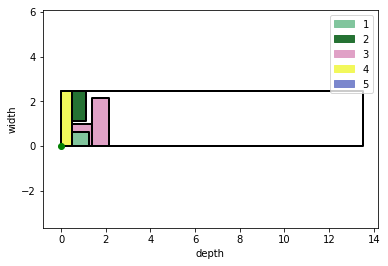

In [19]:
BP_plot.plotSolution(s)

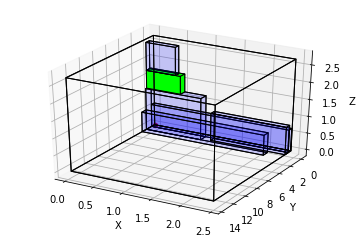

In [24]:
BP_plot.plot3DSolution(s,0,3)

In [21]:
print s


BIN: (w,d,h) = (2.45,13.5,2.7)
[Anchors]:
Point: (x,y,z) = (0.0,0.508198527124,0.0), Item: [0 (3)] (w,d,h) = (0.988734176028,0.891640868361,1.2533451662), weight = 4.0
Point: (x,y,z) = (0.0,0.682573865882,1.78470682658), Item: [1 (5)] (w,d,h) = (0.520909938877,0.56961777811,0.81918742003), weight = 4.0
Point: (x,y,z) = (0.0,1.39983939548,0.0), Item: [2 (3)] (w,d,h) = (2.17100720403,0.736231423688,0.603456589731), weight = 4.0
Point: (x,y,z) = (0.0,0.508198527124,1.2533451662), Item: [3 (1)] (w,d,h) = (0.743993116868,0.609055433307,0.531361660379), weight = 4.0 [R] 
Point: (x,y,z) = (1.13985211105,0.508198527124,0.0), Item: [4 (2)] (w,d,h) = (1.31014788895,0.606623269235,0.826942379479), weight = 4.0
Point: (x,y,z) = (0.0,0.0,0.0), Item: [5 (4)] (w,d,h) = (2.44279720628,0.508198527124,0.679007649759), weight = 4.0
-----------
[Extreme Points]:
(x,y,z) = (0.0,0.0,0.0)
-----------

BIN: (w,d,h) = (0.0,0.0,0.0)
[Anchors]:

-----------
[Extreme Points]:
(x,y,z) = (0.0,0.0,0.0)
-----------


In [38]:
dimensioni =pd.DataFrame({'n_items': n_items,'Eu obj': eu_obj,'Mod obj': mod_obj, 'Time': Time, 'Stable': feasible})

In [39]:
dimensioni.to_excel('result.xlsx', encoding='utf8')
dimensioni.to_latex('result.tex', encoding='utf8')
dimensioni.to_csv('result.csv', encoding='utf8')

In [41]:
dimensioni

,Eu obj,Mod obj,Stable,Time,n_items
0,4.014308,3.151733,True,8.385,7


In [ ]:
#send_mail()